In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


y_true = ["Centro", "Noroeste", "Sureste", "Suroeste", "Noreste", "Centro", "Suroeste"]
y_pred = ["Centro", "Suroeste", "Sureste", "Noroeste", "Noreste", "Noreste", "Centro"]

def get_region_coords():
    return {
        "Noroeste": (1, 3),
        "Noreste": (3, 3),
        "Suroeste": (1, 1),
        "Sureste": (3, 1),
        "Centro": (2, 2),
        "Ávila": (2, 2),
    }

def region_accuracy_geografica(y_true, y_pred, mapa=None, tolerancia=1.5):
    if mapa is None:
        mapa = get_region_coords()
    
    correctas = 0
    total = len(y_true)

    for real, pred in zip(y_true, y_pred):
        if real == pred:
            correctas += 1
        else:
            x1, y1 = mapa.get(real, (0,0))
            x2, y2 = mapa.get(pred, (0,0))
            dist = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
            if dist <= tolerancia:
                correctas += 0.5
    return correctas / total

precision_basica = accuracy_score(y_true, y_pred)
precision_geo = region_accuracy_geografica(y_true, y_pred)

print(f"Precisión tradicional: {precision_basica:.2f}")
print(f"Precisión geográfica (con tolerancia): {precision_geo:.2f}")


Precisión tradicional: 0.43
Precisión geográfica (con tolerancia): 0.57


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

csv_path = "etiquetas_danas_restringido_ajustado.csv"  
image_dir = "IMÁGENES"  
img_size = (224, 224)

def cargar_datos(csv_path, image_dir, img_size=(224, 224)):
    df = pd.read_csv(csv_path)
    df = df[df['dana'] == 'SI']  

    labels = df[['nombre_archivo', 'tipo_peligrosidad', 'zonas_afectadas']].drop_duplicates()
    X, y_level, y_region = [], [], []

    for _, row in labels.iterrows():
        img_path = os.path.join(image_dir, row['nombre_archivo'])
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB").resize(img_size)
            X.append(np.array(img))
            y_level.append(row['tipo_peligrosidad'])
            y_region.append(row['zonas_afectadas'])

    X = np.array(X) / 255.0
    level_enc = LabelEncoder().fit(y_level)
    region_enc = LabelEncoder().fit(y_region)

    y_level_encoded = level_enc.transform(y_level)
    y_region_encoded = region_enc.transform(y_region)

    return X, y_level_encoded, y_region_encoded, level_enc, region_enc

def crear_modelo(num_levels, num_regions):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    out_level = tf.keras.layers.Dense(num_levels, activation='softmax', name='level')(x)
    out_region = tf.keras.layers.Dense(num_regions, activation='softmax', name='region')(x)

    model = tf.keras.Model(inputs=inputs, outputs=[out_level, out_region])
    model.compile(optimizer='adam',
                  loss={'level': 'sparse_categorical_crossentropy', 'region': 'sparse_categorical_crossentropy'},
                  metrics={'level': 'accuracy', 'region': 'accuracy'})
    return model

def evaluar_modelo(model, X_test, y_level_test, y_region_test):
    results = model.evaluate(X_test, {'level': y_level_test, 'region': y_region_test}, verbose=0)
    print(f"Accuracy del nivel DANA: {results[3]*100:.2f}%")
    print(f"Accuracy de la región afectada: {results[4]*100:.2f}%")

region_coords = {
    'Región de Murcia': (140, 130, 170, 160),
    'Comunidad Valenciana': (150, 110, 190, 140),
    'Andalucía Oriental': (120, 150, 160, 180),
    'Andalucía Occidental': (70, 150, 110, 180),
    'Extremadura': (60, 120, 100, 150),
    'Castilla-La Mancha': (100, 90, 140, 120),
    'Ávila': (90, 80, 110, 100),
    'Centro': (110, 90, 130, 110),
    'Sureste': (150, 140, 180, 170),
    'Noroeste': (60, 60, 90, 90),
    'Noreste': (150, 60, 180, 90),
    'Suroeste': (60, 140, 90, 170)
}

def predecir_dana_en_imagen(model, img_path, level_enc, region_enc):
    img = Image.open(img_path).convert('RGB').resize((224, 224))
    arr = np.expand_dims(np.array(img) / 255.0, axis=0)

    pred_level, pred_region = model.predict(arr, verbose=0)
    level = level_enc.inverse_transform([np.argmax(pred_level)])[0]
    region = region_enc.inverse_transform([np.argmax(pred_region)])[0]

    print(f"Región: {region}")
    print(f"Nivel de peligrosidad: {level.upper()}")

    img_cv = np.array(img)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

    color = {
        'BAJA': (0, 255, 0),
        'MEDIA': (0, 255, 255),
        'ALTA': (255, 0, 0)
    }.get(level.upper(), (255, 255, 255))

    if region in region_coords:
        x1, y1, x2, y2 = region_coords[region]
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 3)

    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Predicción IA sobre riesgo de DANA")
    plt.show()

X, y_level, y_region, level_enc, region_enc = cargar_datos(csv_path, image_dir)
X_train, X_test, y_level_train, y_level_test, y_region_train, y_region_test = train_test_split(
    X, y_level, y_region, test_size=0.2, random_state=42
)

model = crear_modelo(num_levels=len(level_enc.classes_), num_regions=len(region_enc.classes_))
model.fit(X_train, {'level': y_level_train, 'region': y_region_train}, epochs=10, batch_size=8)

evaluar_modelo(model, X_test, y_level_test, y_region_test)


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - level_accuracy: 0.3582 - level_loss: 8.6809 - loss: 42.5844 - region_accuracy: 0.2542 - region_loss: 33.5191
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - level_accuracy: 0.4895 - level_loss: 1.0644 - loss: 2.6297 - region_accuracy: 0.3428 - region_loss: 1.5628
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - level_accuracy: 0.5099 - level_loss: 0.9237 - loss: 2.3658 - region_accuracy: 0.2409 - region_loss: 1.4425
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - level_accuracy: 0.6134 - level_loss: 0.9506 - loss: 2.2911 - region_accuracy: 0.2876 - region_loss: 1.3426
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - level_accuracy: 0.5325 - level_loss: 0.9816 - loss: 2.3436 - region_accuracy: 0.2663 - region_loss: 1.3616
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - level_accuracy: 0.7338 - level_loss: 0.7831 - loss: 2.1127 - region_accuracy: 0.3841 - region_loss: 1.3304
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 421ms

Región: Noroeste
Nivel de peligrosidad: BAJA


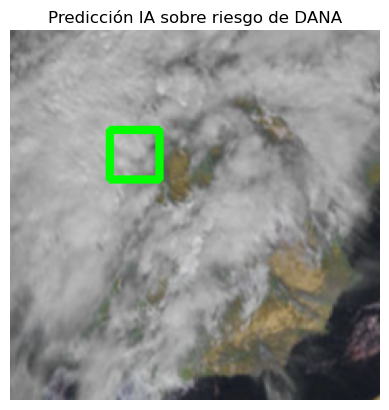

In [3]:
predecir_dana_en_imagen(model, os.path.join(image_dir, "26-01-2025.png"), level_enc, region_enc)

In [5]:
def predecir_varias_danas_en_imagen(model, img_path, level_enc, region_enc, original_size=(224, 224)):
    from PIL import Image
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    img_original = Image.open(img_path).convert('RGB').resize(original_size)
    img_arr = np.array(img_original)
    resultados = []

    region_coords = {
        'Noroeste': (10, 10, 90, 90),
        'Noreste': (130, 10, 210, 90),
        'Centro': (80, 80, 150, 150),
        'Suroeste': (10, 130, 90, 210),
        'Sureste': (130, 130, 210, 210)
    }

    img_cv = cv2.cvtColor(np.array(img_original), cv2.COLOR_RGB2BGR)

    for region, (x1, y1, x2, y2) in region_coords.items():
        recorte = img_arr[y1:y2, x1:x2]
        if recorte.shape[0] == 0 or recorte.shape[1] == 0:
            continue

        brightness = recorte.mean(axis=2)
        white_pixels = np.sum(brightness > 200)
        ratio_nubes = white_pixels / (recorte.shape[0] * recorte.shape[1])

        if ratio_nubes < 0.06:
            continue  
        recorte_resized = cv2.resize(recorte, (224, 224)) / 255.0
        entrada = np.expand_dims(recorte_resized, axis=0)

        pred_level, pred_region = model.predict(entrada, verbose=0)
        level = level_enc.inverse_transform([np.argmax(pred_level)])[0]

        if level.upper() != "NINGUNA":
            color = {
                'BAJA': (0, 255, 0),
                'MEDIA': (0, 255, 255),
                'ALTA': (255, 0, 0)
            }.get(level.upper(), (255, 255, 255))

            cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_cv, f"{region} ({level.upper()})", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

            resultados.append((region, level))

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Predicción IA: múltiples DANAs")
    plt.show()

    for region, level in resultados:
        print(f"Región: {region} → Nivel: {level.upper()}")


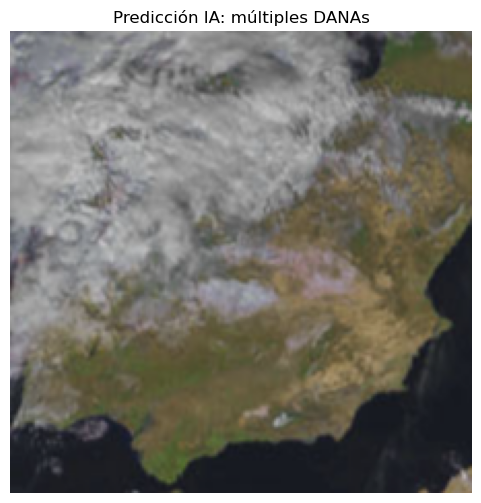

In [14]:
predecir_varias_danas_en_imagen(model, "IMÁGENES/07-01-2025.png", level_enc, region_enc)

In [ ]:
def predecir_varias_danas_en_imagen(model, img_path, level_enc, region_enc, original_size=(224, 224)):
    from PIL import Image
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt

    img_original = Image.open(img_path).convert('RGB').resize(original_size)
    img_arr = np.array(img_original)
    img_cv = cv2.cvtColor(img_arr, cv2.COLOR_RGB2BGR)

    region_coords = {
        'Noroeste': (10, 10, 90, 90),
        'Noreste': (130, 10, 210, 90),
        'Centro': (80, 80, 150, 150),
        'Suroeste': (10, 130, 90, 210),
        'Sureste': (130, 130, 210, 210)
    }

    resultados = []

    for region, (x1, y1, x2, y2) in region_coords.items():
        recorte = img_arr[y1:y2, x1:x2]
        if recorte.shape[0] == 0 or recorte.shape[1] == 0:
            continue

        brightness = recorte.mean(axis=2)
        white_pixels = np.sum(brightness > 200)
        ratio_nubes = white_pixels / (recorte.shape[0] * recorte.shape[1])

        if ratio_nubes < 0.10:
            continue

        recorte_resized = cv2.resize(recorte, (224, 224)) / 255.0
        entrada = np.expand_dims(recorte_resized, axis=0)
        pred_level, pred_region = model.predict(entrada, verbose=0)

        level = level_enc.inverse_transform([np.argmax(pred_level)])[0]
        if level.upper() == "NINGUNA":
            continue

        color = {
            'BAJA': (0, 255, 0),
            'MEDIA': (0, 255, 255),
            'ALTA': (255, 0, 0)
        }.get(level.upper(), (255, 255, 255))

        cv2.rectangle(img_cv, (x1, y1), (x2, y2), color, 2)
        resultados.append((region, level))

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Predicción IA: múltiples DANAs")
    plt.show()

    if resultados:
        print("Predicciones de DANAs detectadas por región:")
        for region, level in resultados:
            print(f"Región: {region} → Nivel de peligrosidad: {level.upper()}")
    else:
        print("No se detectó ninguna DANA significativa en esta imagen.")


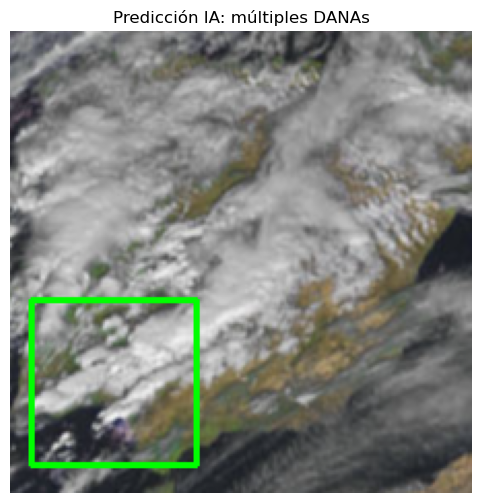

🌀 Predicciones de DANAs detectadas por región:
✅ Región: Suroeste → Nivel de peligrosidad: BAJA


In [32]:
predecir_varias_danas_en_imagen(model, "IMÁGENES/22-01-2025.png", level_enc, region_enc)
